In [2]:
# imports
import numpy as np
import random
from math import comb
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister


In [4]:
from qiskit_finance.circuit.library.probability_distributions.normal import (
    NormalDistribution,
)

z_max = 3
n_z = 5


# generate probability distribution
p = NormalDistribution(
    n_z,
    0,
    1,
    bounds=(-z_max, z_max),
).probabilities

In [5]:
len(p)

32

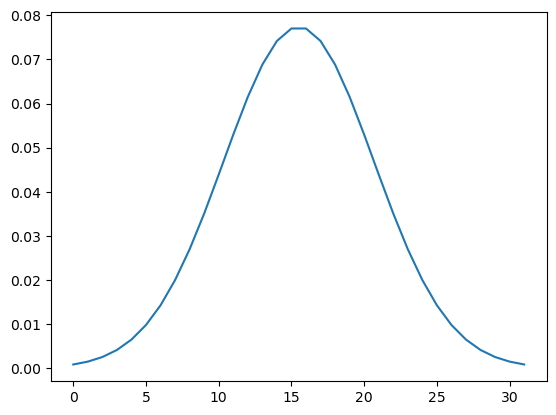

In [6]:
import matplotlib.pyplot as plt

plt.plot(p)
plt.show()

In [7]:
# Deconvolution using Polynomial Factoring

# finds roots of polynomial coefficients
def find_roots(coeffs):
    return np.polynomial.polynomial.polyroots(coeffs)

# groups the roots by real roots, complex roots with positive real component, and complex roots with negative real component
def group_roots(roots):
    comp_root_real_pos = np.array([])
    comp_root_real_neg = np.array([])
    real_root = np.array([])

    for i in roots:
        if (np.isreal(i)):
            real_root = np.append(real_root, i)
        elif (np.real(i) >= 0):
            comp_root_real_pos = np.append(comp_root_real_pos, i)
        elif (np.real(i) < 0):
            comp_root_real_neg = np.append(comp_root_real_neg, i)

    return comp_root_real_pos, comp_root_real_neg, real_root

# function that pairs up a list of complex conjugates
def find_conjugate_pairs(arr):
    conjugate_pairs = []
    n = len(arr)
    used = set()  # To track indices of elements already paired

    for i in range(n):
        if i in used:
            continue
        for j in range(i + 1, n):
            if j in used:
                continue
            # Check if arr[j] is the conjugate of arr[i]
            if arr[i] == np.conj(arr[j]):
                conjugate_pairs.append([arr[i], arr[j]])
                used.update([i, j])
                break

    return np.array(conjugate_pairs)

# generates a list of polynomial factors a given polynomial
# described in the Sharma et. al. paper
def list_of_factors(p):
    # find roots of p
    r = find_roots(p)

    # group roots of p
    pos, neg, real = group_roots(r)

    # generate 1
    pos = np.sort(pos)
    basket1 = list(find_conjugate_pairs(pos))

    # generate basket 2
    neg_paired = find_conjugate_pairs(neg)
    basket2 = list(neg_paired)
    basket2.append(np.array([real]))
    random.shuffle(basket2)

    # processed_baskets = []
    # while len(basket1) > 0:
    #     temp_array = basket1.pop(0)  # Pop the first element from basket1
    #     temp_boolean = True
    #     while temp_boolean and basket2:
    #         random_index = random.randint(0, len(basket2) - 1)
    #         temp_array.append(basket2.pop(random_index))  # Pop the element at random_index from basket2
    #         print(temp_array)
    #         poly_coeff = np.poly(temp_array)
    #         if any(c.real <= 0 for c in poly_coeff):
    #             temp_boolean = False
    #         else:
    #             processed_baskets.append(temp_array)
    #             temp_array = [basket1.pop(0)] if basket1 else []


    while len(basket1) > 0:
        temp_array = basket1[0]
        temp_boolean = True

        while temp_boolean and basket2:
            random_index = random.randint(0, len(basket2) - 1)
            temp_array = np.append(temp_array, basket2[random_index])
            poly_coeff = np.poly(temp_array)
            basket2.pop(random_index)

            # The paper switched these Trues and Falses, but this worked better
            if any(c.real <= 0 for c in poly_coeff):
                temp_boolean = True
            else:
                temp_boolean = False

        basket2.append(temp_array)
        basket1.pop(0)


    list_of_poly_factors = []
    for i in basket2:
        temp = np.poly(i)
        list_of_poly_factors.append(temp / np.sum(temp))

    return list_of_poly_factors

# generates a deconvolution of p
def PMF_deconvolution(p):

    # generates a list of 5000 polynomial factorizations of p
    list_of_factorizations = []
    for i in range(5000):
        list_of_factorizations.append(list_of_factors(p))
        
    list_of_factorizations = sorted(list_of_factorizations, key=lambda x: len(x), reverse = True)

    # chooses the best factorization by choosing the one with the most factors
    max_factors = len(list_of_factorizations[0])
    # print(max_factors)

    list_of_max_factorized = []
    i = 0
    while len(list_of_factorizations[i]) == max_factors:
        list_of_max_factorized.append(list_of_factorizations[i])
        i += 1

    for i in range(len(list_of_max_factorized)):
        list_of_max_factorized[i] = sorted(list_of_max_factorized[i], key=lambda x: len(x), reverse=True)

    # from the factorizations with the most factors, this chooses the one with the smallest maximum degree fractor
    best_factorized = min(list_of_max_factorized, key=lambda x: len(x[0]))
    
    # print(len(list_of_max_factorized))
    # print(list_of_max_factorized)
    # print(best_factorized)

    # generates q1 and q2
    q1 = best_factorized[0]
    #q2 is the product of the remaining factors
    q2 = [1]
    for i in range(1, len(best_factorized)):
        q2 = np.polymul(best_factorized[i], q2)
    
    # print(q1)
    # print(q2)

    return q1, q2

q1, q2 = PMF_deconvolution(p)

In [8]:
print(q1)
print(q2)

print((len(q1), len(q2)))

[0.03223644 0.0030071  0.01668713 0.04143471 0.03141138 0.05318798
 0.06101098 0.0984437  0.12193727 0.08128661 0.12193727 0.0984437
 0.06101098 0.05318798 0.03141138 0.04143471 0.01668713 0.0030071
 0.03223644]
[0.02666024 0.04427587 0.06107664 0.06569373 0.08092418 0.09714797
 0.12422138 0.12422138 0.09714797 0.08092418 0.06569373 0.06107664
 0.04427587 0.02666024]
(19, 14)


In [9]:
# checks that q1 and q2 is a valid deconvolution of p
np.polymul(q1, q2) - p

array([ 4.28259858e-17,  6.89552582e-17,  1.26634814e-16,  1.95156391e-16,
        2.80157841e-16,  2.93168267e-16,  2.82759927e-16,  2.15105711e-16,
        1.04083409e-16,  9.02056208e-17, -2.28983499e-16, -2.35922393e-16,
       -5.89805982e-16, -7.63278329e-16, -6.66133815e-16, -6.38378239e-16,
       -6.10622664e-16, -4.44089210e-16, -3.19189120e-16, -2.08166817e-16,
        1.73472348e-16,  2.91433544e-16,  3.40005801e-16,  4.02455846e-16,
        4.05925293e-16,  4.00721123e-16,  3.52148866e-16,  2.74086309e-16,
        2.18575158e-16,  1.07552856e-16,  8.34835673e-17,  4.18502039e-17])

In [10]:
# def prepareRegister(f1, f2, n, circuit):
#     #require that these functions are of the same length
    
#     circuit.initalize(f1, [x for x in range(0, n)])
#     circuit.initalize(f2, [x for x in range(n, 2*n)])

4
5
[0.17954509 0.05483699 0.12917866 0.20355518 0.17723256 0.2306252
 0.24700402 0.31375739 0.34919518 0.28510807 0.34919518 0.31375739
 0.24700402 0.2306252  0.17723256 0.20355518 0.12917866 0.05483699
 0.17954509 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.16327964 0.21041832 0.24713688 0.25630789 0.28447175 0.31168568
 0.35245053 0.35245053 0.31168568 0.28447175 0.25630789 0.24713688
 0.21041832 0.16327964 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


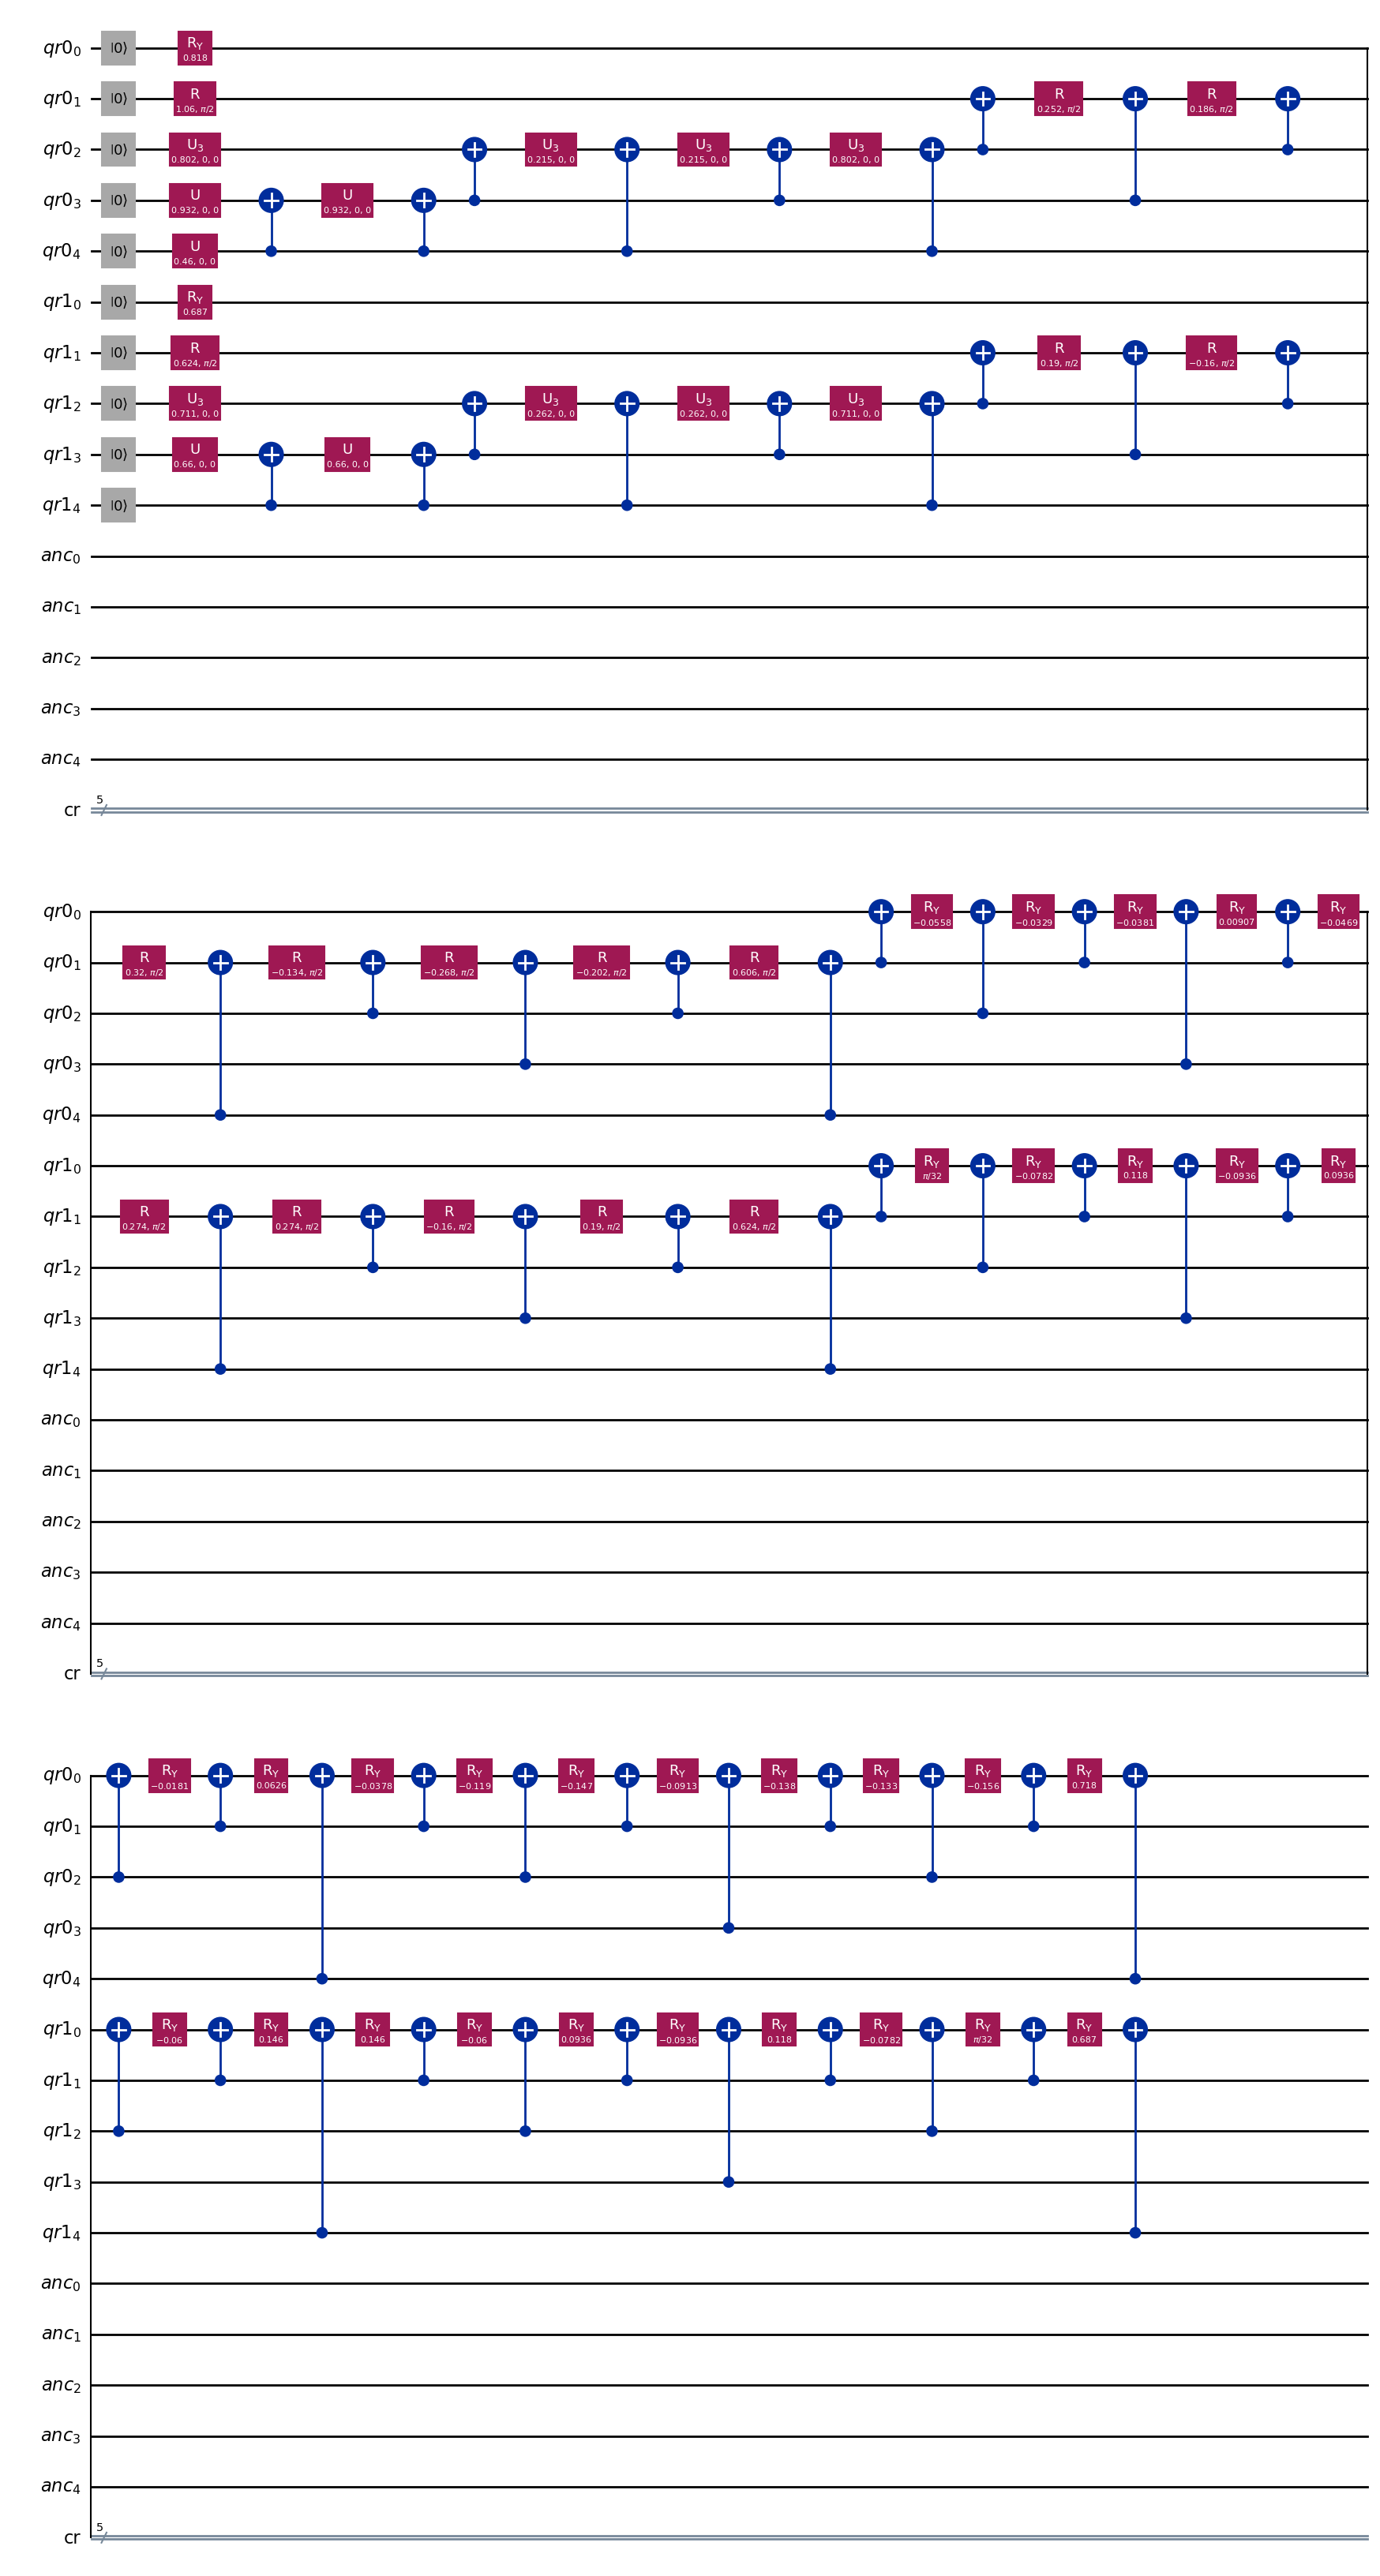

In [14]:
# quantum amplitudes from q1 and q2 probability distributions
amplitudes_q1 = np.sqrt(q1)
amplitudes_q2 = np.sqrt(q2)

# calculates the number of qubits needed 
n1 = int(np.ceil(np.log2(np.floor((len(p) + 1)/ 2))))
n2 = int(np.ceil(np.log2(np.ceil((len(p) + 1)/ 2))))

print(n1)
print(n2)

if n1 > n2:
    temp = amplitudes_q1
    amplitudes_q1 = amplitudes_q2
    amplitudes_q2 = temp

    temp2 = n1
    n1 = n2
    n2 = temp2

# pads the lists with zeros
amplitudes_q1.resize(2 ** n2)
amplitudes_q2.resize(2 ** n2)

print(amplitudes_q1)
print(amplitudes_q2)

# create the circuit with two recisters for q1 and q2, an ancilla qubit register, and a classical register
qr0 = QuantumRegister(n2, 'qr0')
qr1 = QuantumRegister(n2, 'qr1')
anc = QuantumRegister(n2, "anc")
cr = ClassicalRegister(n2, "cr")
circuit = QuantumCircuit(qr0, qr1, anc, cr)

# Uses the initialize function to create the state preperation gate
circuit.initialize(amplitudes_q1, [x for x in range(0, n2)])
circuit.initialize(amplitudes_q2, [x for x in range(n2, 2*n2)])


circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl') 

In [12]:
# Quantum adder
def quantum_adder(qc, phi_1, phi_2, ancilla, cr, n, measure):
    # Create Quantum Registers for the input states and ancilla qubits
    #phi_1 = QuantumRegister(n, 'phi1')
    #phi_2 = QuantumRegister(n, 'phi2')
    #ancilla = QuantumRegister(n, 'ancilla')

   
    # Create a Quantum Circuit with the registers
    #qc = QuantumCircuit(phi_1, phi_2, ancilla)
   
    # Apply CCX gates (Toffoli gates) as per the pseudo code
    for i in range(n):
        qc.ccx(phi_1[i], phi_2[i], ancilla[i])
   
    # Apply CX gates (CNOT gates) as per the pseudo code
    for i in range(n):
        qc.cx(phi_1[n-i-1], phi_2[n-i-1])
   
    # Apply CCX gates with control qubits from phi_2 and ancilla, target to ancilla
    for i in range(1, n):
        qc.ccx(phi_2[i], ancilla[i-1], ancilla[i])
   
    # Apply CX gates with control qubits from ancilla, target to phi_2
    for i in range(n-1):
        qc.cx(ancilla[i], phi_2[i+1])
   

    if measure:
        # Measure the second register (phi_2) to get the result of addition
        qc.measure(phi_2, cr)
   
    # Return the quantum circuit
    return qc



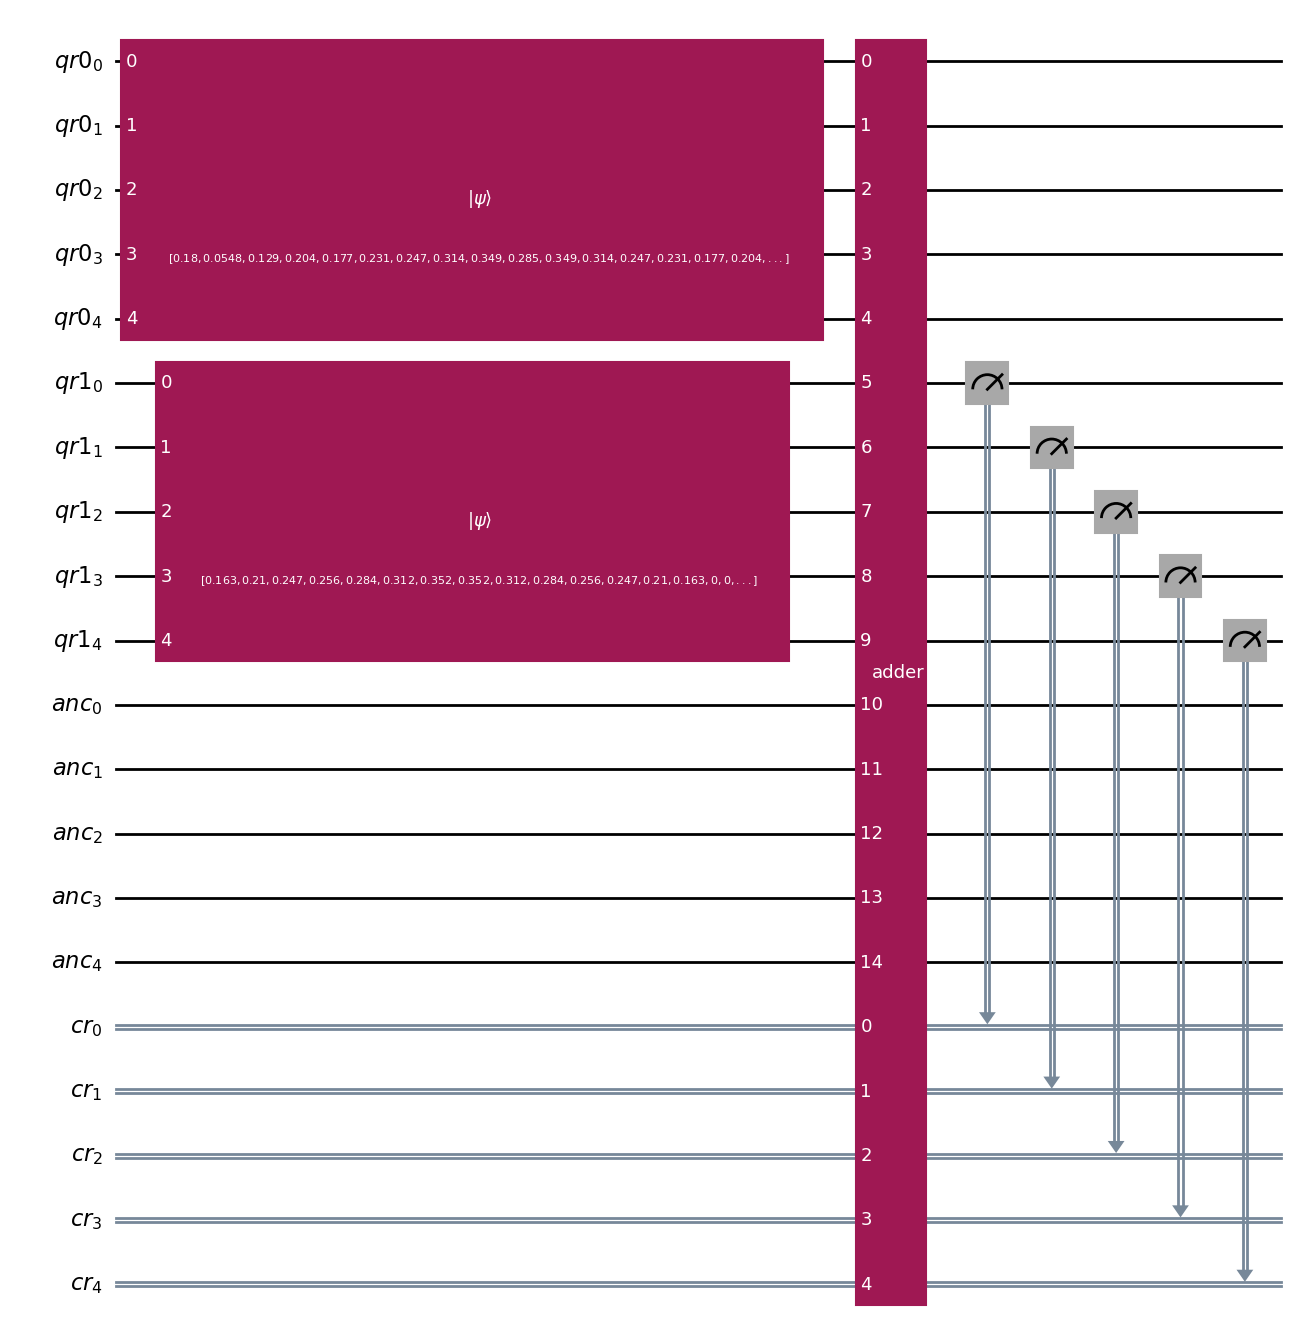

In [15]:
# inserts the quantum adder to the circuit

adder = QuantumCircuit(qr0, qr1, anc, cr, name="adder")
quantum_adder(adder, qr0, qr1, anc, cr, n2, False)

circuit.append(adder, list(range(3*n2)), list(range(n2)))

circuit.measure(qr1, cr)

circuit.draw('mpl') 

In [20]:
# Code from problem setting notebook

from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter

# Converts circuit to tket format
tket_circuit = qiskit_to_tk(circuit)
render_circuit_jupyter(tket_circuit)

In [21]:
from pytket.transform import Transform
Transform.DecomposeBoxes().apply(tket_circuit)

render_circuit_jupyter(tket_circuit)

tket_circuit.depth()

65

In [22]:
from pytket.extensions.nexus import Nexus
from datetime import datetime

nexus = Nexus()
my_project = nexus.new_project()


New project created: project-conical-silky-ebullient-claroflava


In [23]:
from pytket.extensions.nexus import QuantinuumConfig


configuration = QuantinuumConfig(device_name="H1-1LE")

In [24]:
from pytket.extensions.nexus import NexusBackend

# Then we'll create a NexusBackend using our config and the project we created
backend_LE = NexusBackend(configuration, project=my_project)

compiled_circ_Hseries_LE = backend_LE.get_compiled_circuit(tket_circuit, optimisation_level = 2)


Started using project with name: project-conical-silky-ebullient-claroflava


In [25]:
handle_LE =  backend_LE.process_circuit(compiled_circ_Hseries_LE, n_shots=1024)
print(backend_LE)

In [26]:
status = backend_LE.circuit_status(handle_LE)
print(status)

CircuitStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Circuit has been submitted to Nexus for Processing.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 4, 14, 12, 51, 29, 851517, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [27]:
from pytket.extensions.qiskit import AerBackend
aer_b = AerBackend()

n_shots = 1024

handle = aer_b.process_circuit(tket_circuit, n_shots=n_shots, seed=1)
counts = aer_b.get_result(handle).get_counts()

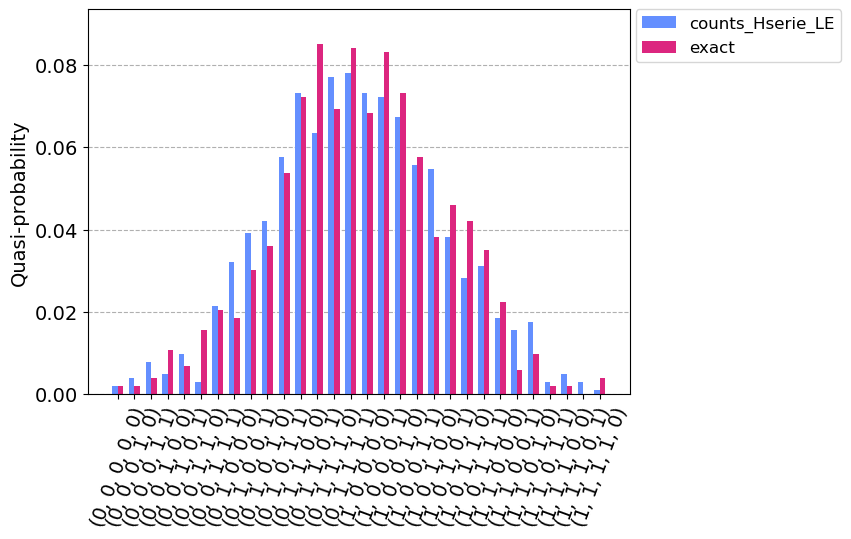

In [28]:
from qiskit.visualization import plot_distribution


result_LE = backend_LE.get_result(handle_LE)
counts_Hserie_LE = result_LE.get_counts()


# Note: state basis numbers in Qiskit and pytket are switched, hence need to be corrected to use the plot_distribution function
counts_Hserie_LE = {key[::-1]: value for key, value in counts_Hserie_LE.items()}
counts_exact = {key[::-1]: value for key, value in counts.items()}

# Now plot the results
plot_distribution(
    [counts_Hserie_LE, counts_exact], legend=["counts_Hserie_LE", "exact"], bar_labels=False
)

Sum of squared errors: 2099.0


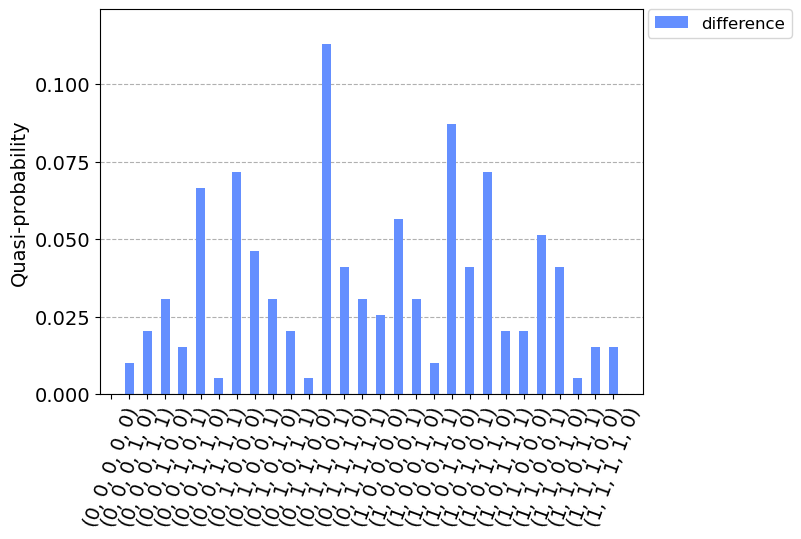

In [114]:
# counts_exact - counts_Hserie_LE

res = {key: abs(counts_exact[key] - counts_Hserie_LE.get(key, 0)) / n_shots
                       for key in counts_exact.keys()}

# calculates the sum of squared errors between the two sampling distributions
print("Sum of squared errors: " + str(sum ((np.array(list(res.values())) * n_shots )**2 )))

# plots the absolute error between the distributions
plot_distribution(
    [res], legend=["difference"], bar_labels=False
)

## Credit Risk analysis

Using the risk analysis code from the 09_credit_risk_analysis notebook

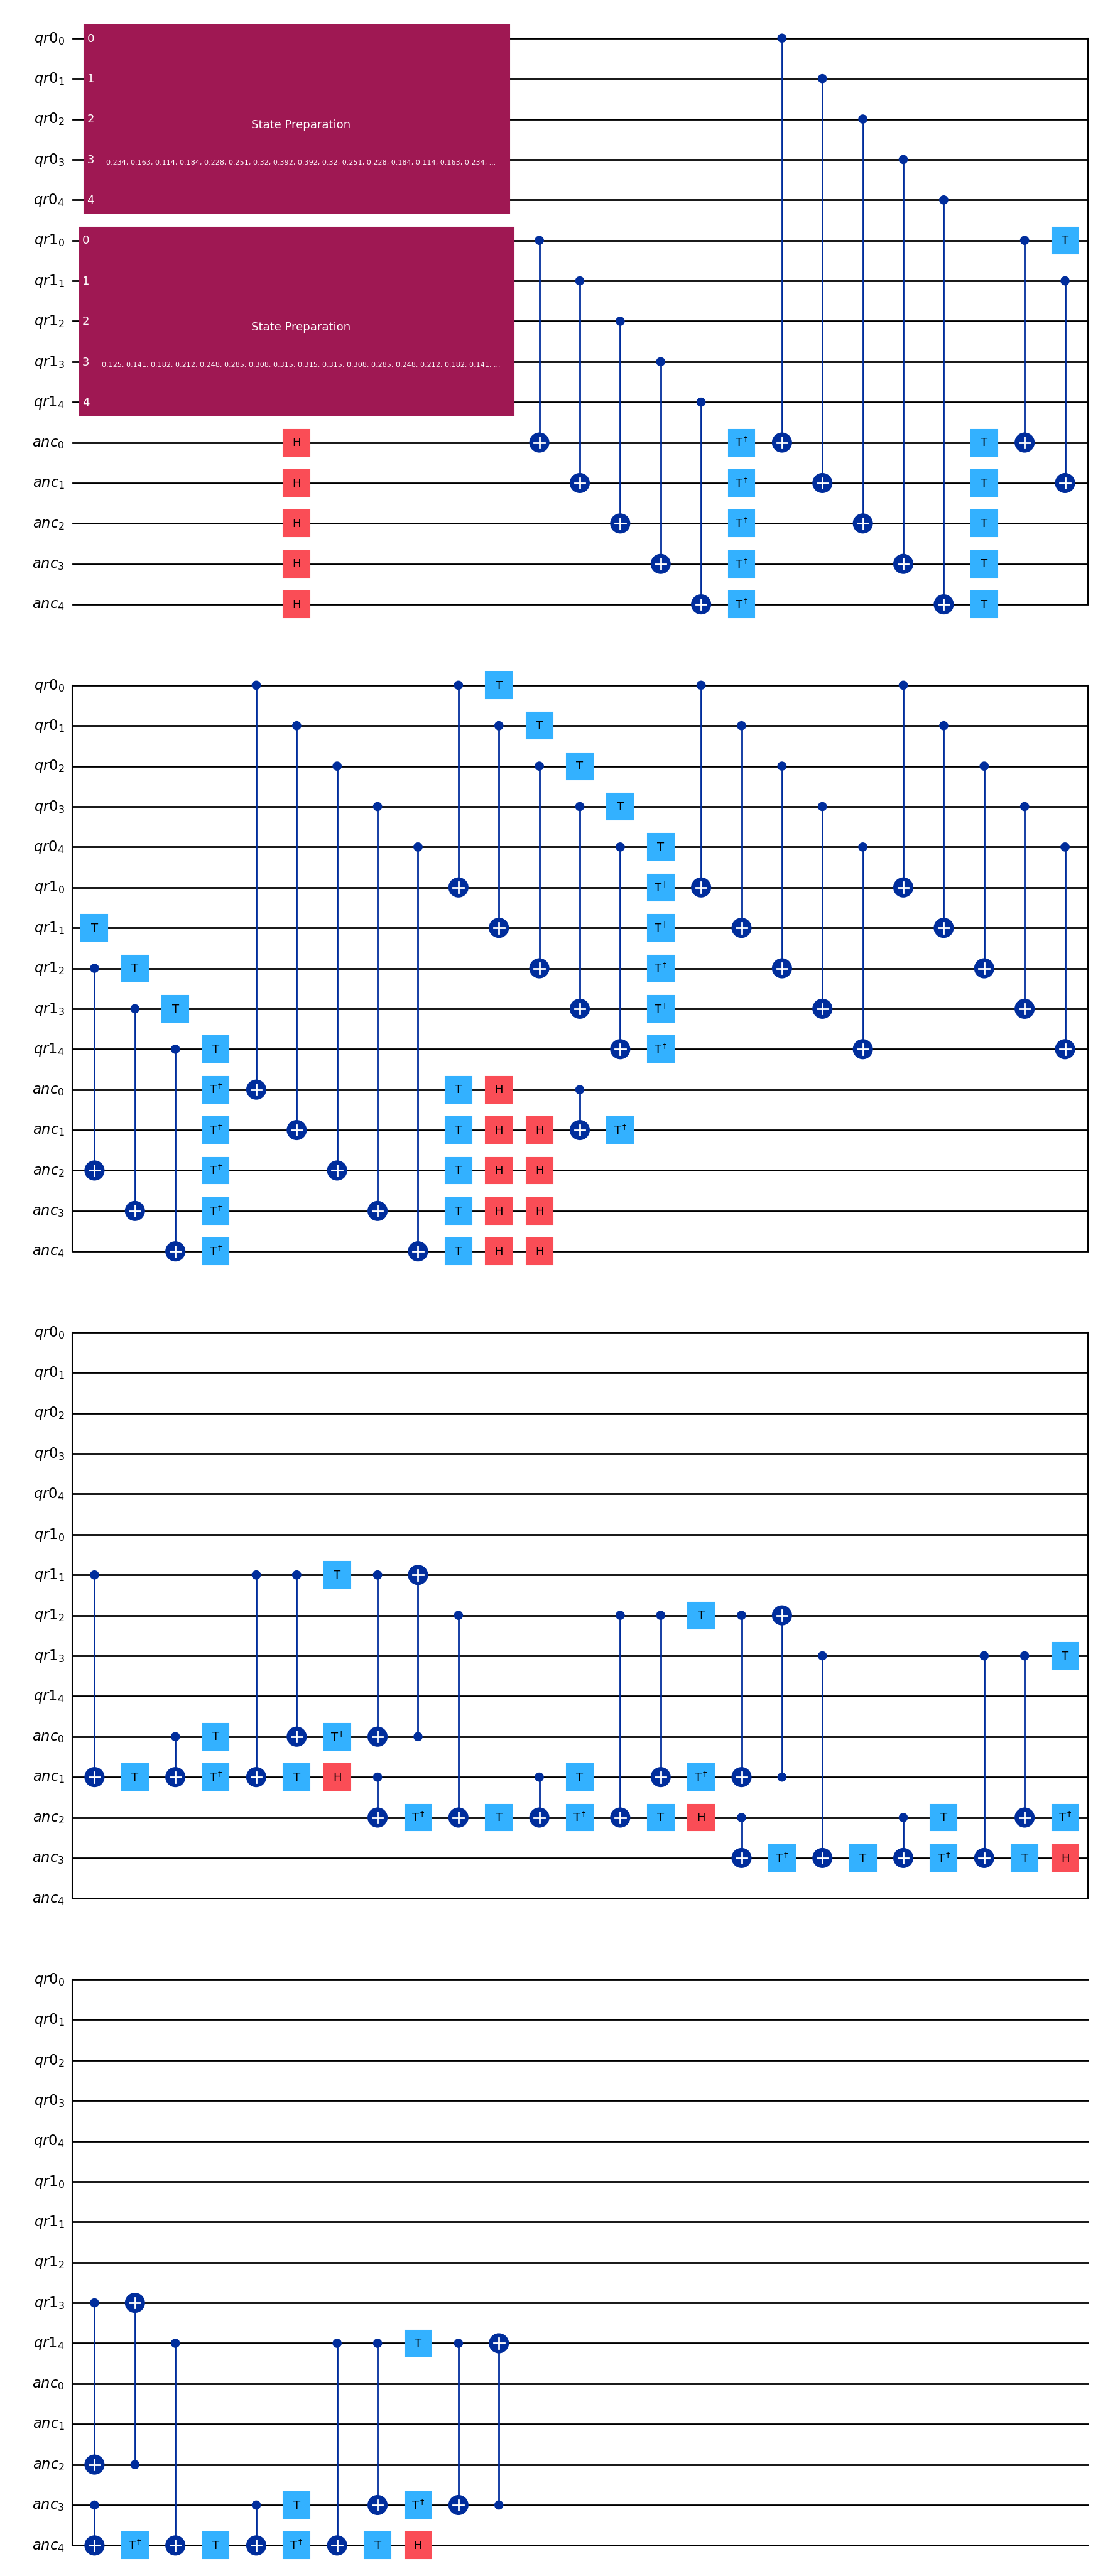

In [62]:
# Creates the same circuit, but as a unitary (no measurements)

qr0_new = QuantumRegister(n2, 'qr0')
qr1_new = QuantumRegister(n2, 'qr1')
anc_new = QuantumRegister(n2, "anc")

unitary = QuantumCircuit(qr0_new, qr1_new, anc_new)

unitary.initialize(amplitudes_q1, [x for x in range(0, n2)])
unitary.initialize(amplitudes_q2, [x for x in range(n2, 2*n2)])

# inserts quantum adder without measurements
quantum_adder(unitary, qr0, qr1, anc, None, n2, False)

unitary = unitary.decompose()

# for index, instruction in enumerate(unitary.data):
#     print(index, instruction.operation.name, [ unitary.find_bit(q).index for q in instruction.qubits])

# deletes reset gates
del unitary.data[10]
del unitary.data[9]
del unitary.data[8]
del unitary.data[7]
del unitary.data[6]
del unitary.data[4]
del unitary.data[3]
del unitary.data[2]
del unitary.data[1]
del unitary.data[0]

# for index, instruction in enumerate(unitary.data):
#     print(index, instruction.operation.name, [ unitary.find_bit(q).index for q in instruction.qubits])

unitary.draw('mpl') 

In [116]:
n_z = 5
z_max = 4
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25, 0.2, 0.1, 0.025]
rhos = [0.1, 0.05, 0.15, 0.05, 0.025]
lgd = [1, 2, 1, 3, 5]
K = len(p_zeros)
alpha = 0.05

In [102]:
import qiskit as q

# took from qiskit_finance.circuit.library
"""The Gaussian Conditional Independence Model for Credit Risk."""

from typing import List, Union
import numpy as np
from scipy.stats.distributions import norm

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import LinearPauliRotations
from qiskit_finance.circuit.library.probability_distributions.normal import (
    NormalDistribution,
)


class GCI(q.QuantumCircuit):
    """The Gaussian Conditional Independence Model for Credit Risk.
    Reference: https://arxiv.org/abs/1412.1183
    Dependency between individual risk variables and latent variable is approximated linearly.
    """

    def __init__(
        self,
        n_normal: int,
        normal_max_value: float,
        p_zeros: Union[List[float], np.ndarray],
        rhos: Union[List[float], np.ndarray],
    ) -> None:
        """
        Args:
            n_normal: Number of qubits to represent the latent normal random variable Z
            normal_max_value: Min/max value to truncate the latent normal random variable Z
            p_zeros: Standard default probabilities for each asset
            rhos: Sensitivities of default probability of assets with respect to latent variable Z
        """
        self.n_normal = n_normal
        self.normal_max_value = normal_max_value
        self.p_zeros = p_zeros
        self.rhos = rhos
        num_qubits = 3 * n_normal + len(p_zeros)

        # get normal (inverse) CDF and pdf (these names are from the paper, therefore ignore
        # pylint)
        def F(x):  # pylint: disable=invalid-name
            return norm.cdf(x)

        def F_inv(x):  # pylint: disable=invalid-name
            return norm.ppf(x)

        def f(x):  # pylint: disable=invalid-name
            return norm.pdf(x)

        # create linear rotations for conditional defaults
        slopes = []
        offsets = []
        for rho, p_zero in zip(rhos, p_zeros):
            psi = F_inv(p_zero) / np.sqrt(1 - rho)

            # compute slope / offset
            slope = -np.sqrt(rho) / np.sqrt(1 - rho)
            slope *= f(psi) / np.sqrt(1 - F(psi)) / np.sqrt(F(psi))
            offset = 2 * np.arcsin(np.sqrt(F(psi)))

            # adjust for integer to normal range mapping
            offset += slope * (-normal_max_value)
            slope *= 2 * normal_max_value / (2**n_normal - 1)

            offsets += [offset]
            slopes += [slope]


        # build circuit
        inner = QuantumCircuit(num_qubits, name="P(X)")
        inner.append(unitary.to_gate(), list(range(3 * n_normal)))
        for k, (slope, offset) in enumerate(zip(slopes, offsets)):
            lry = LinearPauliRotations(n_normal, slope, offset)
            qubits = list(range(n_normal, 2*n_normal)) + [3*n_normal + k]
            inner.append(lry.to_gate(), qubits)

        super().__init__(num_qubits, name="P(X)")
        self.append(inner.to_gate(), inner.qubits)


# Create unitary
u = GCI(n_z, z_max, p_zeros, rhos)

# Draw the unitary (decomposed)
u.decompose().draw()

┌────────────────┐                                                       
 q_0: ┤0               ├───────────────────────────────────────────────────────
      │                │                                                       
 q_1: ┤1               ├───────────────────────────────────────────────────────
      │                │                                                       
 q_2: ┤2               ├───────────────────────────────────────────────────────
      │                │                                                       
 q_3: ┤3               ├───────────────────────────────────────────────────────
      │                │                                                       
 q_4: ┤4               ├───────────────────────────────────────────────────────
      │                │┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
 q_5: ┤5               ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├
      │                ││         ││         ││         ││         ││         │
 q_6: ┤6               ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├
      │                ││         ││         ││         ││         ││         │
 q_7: ┤7  circuit-2092 ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├
      │                ││         ││         ││         ││         ││         │
 q_8: ┤8               ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├
      │                ││         ││         ││         ││         ││         │
 q_9: ┤9               ├┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├
      │                ││         ││         ││         ││         ││         │
q_10: ┤10              ├┤  LinRot ├┤         ├┤         ├┤         ├┤         ├
      │                ││         ││  LinRot ││         ││         ││         │
q_11: ┤11              ├┤         ├┤         ├┤  LinRot ├┤         ├┤         ├
      │                ││         ││         ││         ││  LinRot ││         │
q_12: ┤12              ├┤         ├┤         ├┤         ├┤         ├┤  LinRot ├
      │                ││         ││         ││         ││         ││         │
q_13: ┤13              ├┤         ├┤         ├┤         ├┤         ├┤         ├
      │                ││         ││         ││         ││         ││         │
q_14: ┤14              ├┤         ├┤         ├┤         ├┤         ├┤         ├
      └────────────────┘│         ││         ││         ││         ││         │
q_15: ──────────────────┤5        ├┤         ├┤         ├┤         ├┤         ├
                        └─────────┘│         ││         ││         ││         │
q_16: ─────────────────────────────┤5        ├┤         ├┤         ├┤         ├
                                   └─────────┘│         ││         ││         │
q_17: ────────────────────────────────────────┤5        ├┤         ├┤         ├
                                              └─────────┘│         ││         │
q_18: ───────────────────────────────────────────────────┤5        ├┤         ├
                                                         └─────────┘│         │
q_19: ──────────────────────────────────────────────────────────────┤5        ├
                                                                    └─────────┘

In [103]:
u.add_register(ClassicalRegister(n_z + len(p_zeros)))

u.measure(list(range(n_z, 2*n_z)) + list(range(3*n_z, 3*n_z + len(p_zeros))), list(range(n_z + len(p_zeros))))

u.decompose().draw()

┌────────────────┐                                                     »
  q_0: ┤0               ├─────────────────────────────────────────────────────»
       │                │                                                     »
  q_1: ┤1               ├─────────────────────────────────────────────────────»
       │                │                                                     »
  q_2: ┤2               ├─────────────────────────────────────────────────────»
       │                │                                                     »
  q_3: ┤3               ├─────────────────────────────────────────────────────»
       │                │                                                     »
  q_4: ┤4               ├─────────────────────────────────────────────────────»
       │                │┌─────────┐┌─────────┐   ┌─────────┐   ┌─────────┐   »
  q_5: ┤5               ├┤0        ├┤0        ├───┤0        ├───┤0        ├───»
       │                ││         ││         │   │         │   │         │   »
  q_6: ┤6               ├┤1        ├┤1        ├───┤1        ├───┤1        ├───»
       │                ││         ││         │   │         │   │         │   »
  q_7: ┤7  circuit-2092 ├┤2        ├┤2        ├───┤2        ├───┤2        ├───»
       │                ││         ││         │   │         │   │         │   »
  q_8: ┤8               ├┤3        ├┤3        ├───┤3        ├───┤3        ├───»
       │                ││         ││         │   │         │   │         │   »
  q_9: ┤9               ├┤4        ├┤4        ├───┤4        ├───┤4        ├───»
       │                ││         ││         │   │         │   │         │   »
 q_10: ┤10              ├┤  LinRot ├┤         ├───┤         ├───┤         ├───»
       │                ││         ││  LinRot │   │         │   │         │   »
 q_11: ┤11              ├┤         ├┤         ├───┤  LinRot ├───┤         ├───»
       │                ││         ││         │   │         │   │  LinRot │   »
 q_12: ┤12              ├┤         ├┤         ├───┤         ├───┤         ├───»
       │                ││         ││         │   │         │   │         │   »
 q_13: ┤13              ├┤         ├┤         ├───┤         ├───┤         ├───»
       │                ││         ││         │   │         │   │         │   »
 q_14: ┤14              ├┤         ├┤         ├───┤         ├───┤         ├───»
       └────────────────┘│         ││         │┌─┐│         │   │         │   »
 q_15: ──────────────────┤5        ├┤         ├┤M├┤         ├───┤         ├───»
                         └─────────┘│         │└╥┘│         │┌─┐│         │   »
 q_16: ─────────────────────────────┤5        ├─╫─┤         ├┤M├┤         ├───»
                                    └─────────┘ ║ │         │└╥┘│         │┌─┐»
 q_17: ─────────────────────────────────────────╫─┤5        ├─╫─┤         ├┤M├»
                                                ║ └─────────┘ ║ │         │└╥┘»
 q_18: ─────────────────────────────────────────╫─────────────╫─┤5        ├─╫─»
                                                ║             ║ └─────────┘ ║ »
 q_19: ─────────────────────────────────────────╫─────────────╫─────────────╫─»
                                                ║             ║             ║ »
c9: 10/═════════════════════════════════════════╩═════════════╩═════════════╩═»
                                                5             6             7 »
«                                       
«  q_0: ────────────────────────────────
«                                       
«  q_1: ────────────────────────────────
«                                       
«  q_2: ────────────────────────────────
«                                       
«  q_3: ────────────────────────────────
«                                       
«  q_4: ────────────────────────────────
«       ┌─────────┐   ┌─┐               
«  q_5: ┤0        ├───┤M├───────────────
«       │         │   └╥┘┌─┐            
«  q_6: ┤1        ├────╫─┤M├──────

In [104]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler

In [105]:
exact_sampler = Sampler()
job = exact_sampler.run(u)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [107]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]


values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(
    pdf[(i_var + 1) :]
)

In [108]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                1.2334
Value at Risk VaR[L]:              5.0000
P[L <= VaR[L]]:                    0.9746
Conditional Value at Risk CVaR[L]: 7.2692


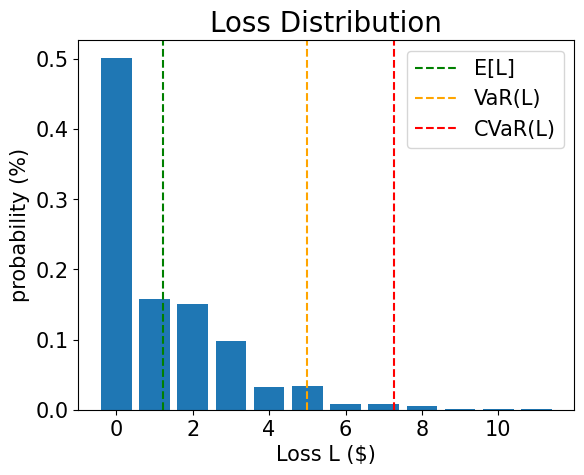

In [109]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

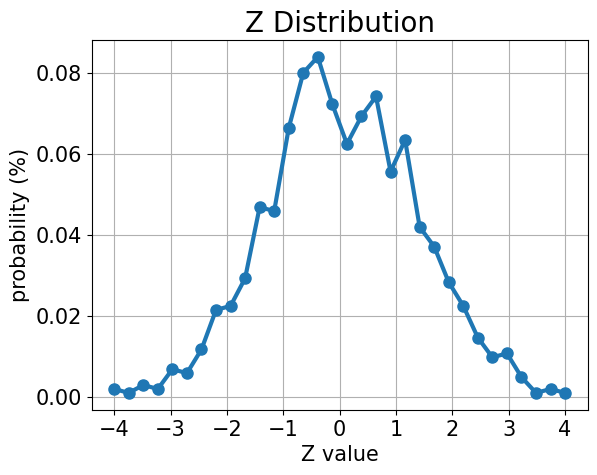

In [110]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

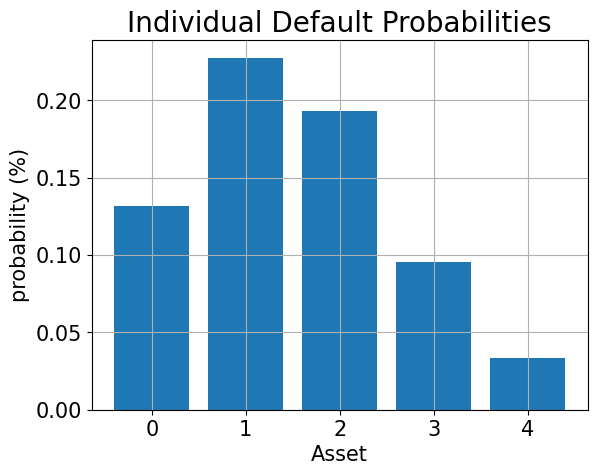

In [111]:
# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [ ]:
# pseudocode for a constant depth recursive algorithm, but exponential circuit width

# def recursiveDeconvolution():
    #deconvulute pdf into p1,p2
    #check the number of qubits represented by p1 p2
    #if (num_qubits_p1 > 5) call recursive deconvulution
        # prepare the states p1a and p1b
        # add them together to get p1
    #if (num_qubits p2 > 5) call recursive deconvulation
        # prepare the states p2a and p2b
        # add them together to get p2
    #add p1 p2 using quantum adder

    #results of p2 gives p_x
